In [1]:
%load_ext autoreload
%autoreload 2
%load_ext watermark
%watermark -v -n -m -p numpy,scipy,sklearn,pandas

Tue Nov 06 2018 

CPython 3.6.6
IPython 6.5.0

numpy 1.15.3
scipy 1.1.0
sklearn 0.19.1
pandas 0.23.4

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.15.0-38-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [47]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import nolds
import data
import mne

PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
DATA_ROOT = os.path.abspath(os.path.join(PROJ_ROOT, 'data'))
PROCESSED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'processed'))
RAW_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'raw'))
LABELED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'labeled'))
DURATIONS_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'durations'))
print(PROJ_ROOT)
print(DATA_ROOT)
print(PROCESSED_ROOT)
import sys
sys.path.append(os.path.join(PROJ_ROOT, 'src'))
CHANNEL_NAMES = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
                 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
META_COLUMN_NAMES = ['freq', 'RESP_4W', 'RESP_FIN', 'REMISE_FIN', 'AGE', 'SEX', 'M_1',
       'M_4', 'M_F', 'délka léčby', 'lék 1', 'lék 2', 'lék 3', 'lék 4']
META_FILE_NAME = 'DEP-POOL_Final_144.xlsx'
meta_df = pd.read_excel(os.path.join(RAW_ROOT, META_FILE_NAME), index_col='ID', names=META_COLUMN_NAMES)

raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '1a.fif'))
t = pd.DataFrame(raw_fif.get_data())
data = pd.DataFrame(np.transpose(t.values), columns=CHANNEL_NAMES)
data = np.transpose(data.values)

/home/miroslav/Source/thesis_project
/home/miroslav/Source/thesis_project/data
/home/miroslav/Source/thesis_project/data/processed
Opening raw data file /home/miroslav/Source/thesis_project/data/processed/1a.fif...
This filename (/home/miroslav/Source/thesis_project/data/processed/1a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 19104 =      0.000 ...    76.416 secs
Ready.


<ipython-input-47-feebbbdfcce0>:29: RuntimeWarning: This filename (/home/miroslav/Source/thesis_project/data/processed/1a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '1a.fif'))


In [142]:
df_X = pd.read_pickle(os.path.join(LABELED_ROOT, 'splits.pickle'))
df_X = df_X.loc[:, (slice(None), [4], slice(None))].unstack().dropna()['lyap'][4]
df_X = df_X.astype(float)
df_yr = pd.read_pickle(os.path.join(LABELED_ROOT, 'labels_response.pickle'))
df_yr.columns = ['label_r']
df_yd = pd.read_pickle(os.path.join(LABELED_ROOT, 'labels_depressed.pickle'))
df_yd.columns = ['label_d']
df_y = df_yr.join(df_yd)
df = df_X.join(df_y)
rows = [row for row in df_X.index if row[0].startswith('b')]
df_aft = df_X.loc[rows, :].join(df_y)
df_aft.index = df_aft.index.map(lambda t: int(t.split('-')[1]))
df_aft = df_aft.sort_index()
rows = [row for row in df_X.index if row[0].startswith('a')]
df_bef = df_X.loc[rows, :].join(df_y)
df_bef.index = df_bef.index.map(lambda t: int(t.split('-')[1]))
df_bef = df_bef.sort_index()

# Before and after comparison plots

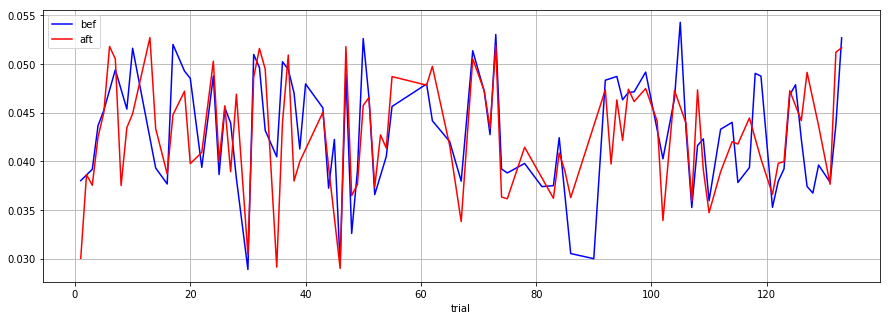

In [165]:
means_bef = df_bef.mean(axis=1)
means_aft = df_aft.mean(axis=1)
plt.figure(figsize=(15,5))
ax1 = means_bef.plot(color='blue', grid=True, label='bef')
ax2 = means_aft.plot(color='red', grid=True, label='aft')
plt.legend()
plt.show()

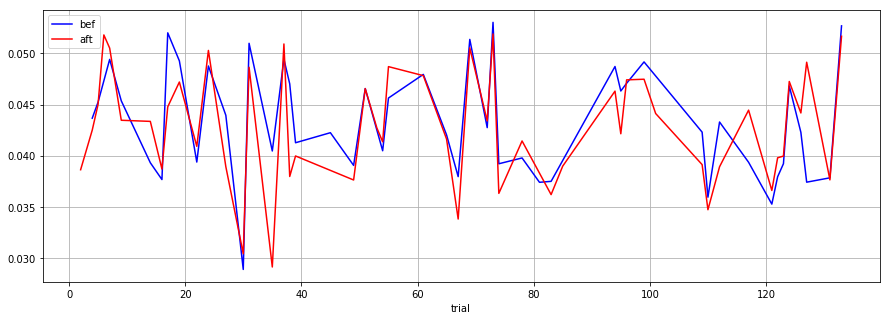

In [109]:
means_bef = df_bef[df_bef['label_r']==0].mean(axis=1)
means_aft = df_aft[df_aft['label_r']==0].mean(axis=1)
plt.figure(figsize=(15,5))
ax1 = means_bef.plot(color='blue', grid=True, label='bef')
ax2 = means_aft.plot(color='red', grid=True, label='aft')
plt.legend()
plt.show()

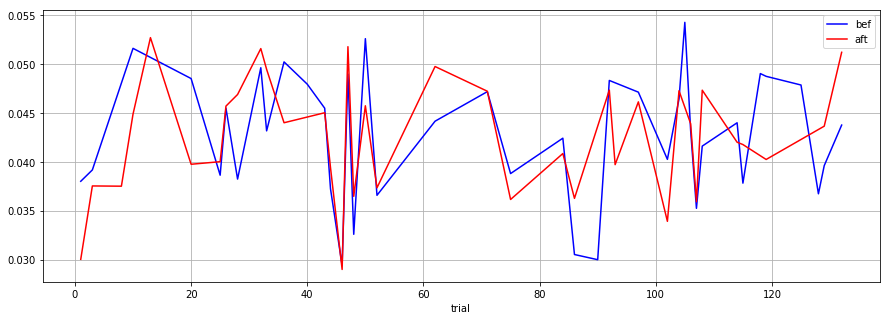

In [113]:
means_bef = df_bef[df_bef['label_r']==1].mean(axis=1)
means_aft = df_aft[df_aft['label_r']==1].mean(axis=1)
plt.figure(figsize=(15,5))
ax1 = means_bef.plot(color='blue', grid=True, label='bef')
ax2 = means_aft.plot(color='red', grid=True, label='aft')
plt.legend()
plt.show()

# Before and after statistical tests

In [167]:
from scipy.stats import ks_2samp
# df_bef.loc[:, map(lambda c: not c.startswith('label'), df_bef.columns)].values
# ks_2samp(df_bef.loc[:, map(lambda c: not c.startswith('label'), df_bef.columns)].values,
#          df_aft.loc[:, map(lambda c: not c.startswith('label'), df_aft.columns)].values)
means_bef = df_bef[df_bef['label_r']==0].mean(axis=1)
means_aft = df_aft[df_aft['label_r']==0].mean(axis=1)
ks_2samp(means_bef, means_aft) # We cannot reject the hypothesis that the distributions are the same

Ks_2sampResult(statistic=0.0857843137254902, pvalue=0.9905859418347901)

# Classification

In [140]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import (SelectFromModel, RFE, SelectKBest, mutual_info_classif)
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

low = df[df['label_d']=='L']
high = df[df['label_d']=='H']
train = low.iloc[:-15, :].append(high.iloc[:-15, :])
test = low.iloc[-15:, :].append(high.iloc[-15:, :])
X_train = train.loc[:, train.columns != 'label_d'].values
y_train = train.loc[:, 'label_d'].values
X_test =  test.loc[:, test.columns != 'label_d'].values
y_test = test.loc[:, 'label_d'].values
 
# skb = SelectKBest(mutual_info_classif, k=15)
# fit = skb.fit(X_train, y_train)
# X_transform = skb.transform(X_train)

lm = LogisticRegression()
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)

print('Coefficients: \n', lm.coef_)
print("Accuracy score: %.2f"
      % accuracy_score(y_test, y_pred))

Coefficients: 
 [[ 0.2855808   0.83886893 -0.37145218  0.47913546 -0.52417824  0.73859432
  -0.07388456  0.38412099  0.02694538  0.81594232  0.47988991 -0.19728068
  -0.31591559  0.21424346 -0.81385217 -0.49425761 -1.61807529  0.36035228
  -0.78008046  0.77797706]]
Accuracy score: 0.57
